# Exercicis OpenCV

Hem vist com ver funcions bàsiques de OpenCV. Ara ho posarem en pràctica.

La teva tasca es posar en pràctica el que has après en quant a processament d'imatges amb un exemple semblant al que hem vist a classe.

## Exercici 1

Utilitzant OpenCV, carrega la imatge `camp.png`, troba les línies i enmarca-les de color verd.

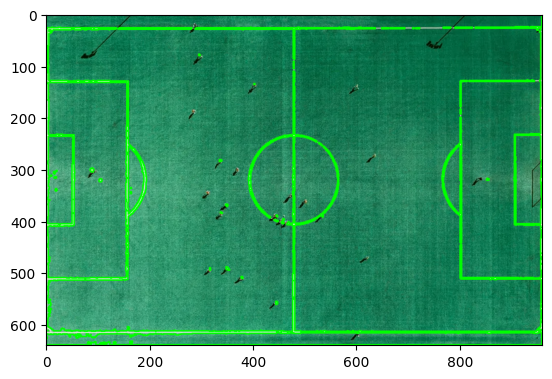

In [61]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def process_image(im):
    im_bn = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im_blurred = cv2.GaussianBlur(im_bn, (5, 5), 0)
    ret, im_th = cv2.threshold(im_blurred,160,255,cv2.THRESH_BINARY_INV)
    im_th_copy = im_th.copy()
    contours, _ = cv2.findContours(im_th_copy, 1, cv2.CHAIN_APPROX_NONE)
    for contour in contours:
        color = (0, 255, 0)

        cv2.drawContours(im, [contour], 0, color, 2)

    return im

im = cv2.imread("camp.png")
im_proc = process_image(im)
plt.imshow(im_proc)